In [87]:
from torchvision.models import vgg19
from torch.autograd import Variable
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [88]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Example of how we can change the ordering of a Tensor

In [89]:
x = torch.Tensor(3, 3, 3)
print(x)

tensor([[[-1.0774e-16,  4.5754e-41, -1.8793e-35],
         [ 3.0620e-41,  4.4842e-44,  0.0000e+00],
         [ 1.3452e-43,  0.0000e+00, -1.1851e+27]],

        [[ 3.0620e-41, -4.0123e-18,  4.5754e-41],
         [ 7.5965e+28,  0.0000e+00,  5.7397e-40],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]])


In [90]:
x[torch.LongTensor([2,1,0])]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 3.0620e-41, -4.0123e-18,  4.5754e-41],
         [ 7.5965e+28,  0.0000e+00,  5.7397e-40],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.0774e-16,  4.5754e-41, -1.8793e-35],
         [ 3.0620e-41,  4.4842e-44,  0.0000e+00],
         [ 1.3452e-43,  0.0000e+00, -1.1851e+27]]])

In [91]:
imsize = 512 

In [92]:
prep = transforms.Compose([transforms.Resize(imsize),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])

In [93]:
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])

In [94]:
postpb = transforms.Compose([transforms.ToPILImage()])

In [95]:
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [96]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(prep(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

### Content image

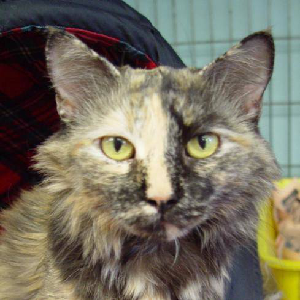

In [112]:
Image.open('Images/cat.10.jpg').resize((300,300))

### Style image

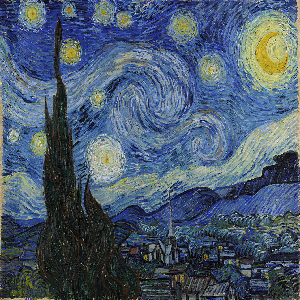

In [113]:
Image.open('Images/vangogh_starry_night.jpg').resize((300,300))

In [98]:
style_img = image_loader("Images/vangogh_starry_night.jpg")
content_img = image_loader("Images/cat.10.jpg")
vgg = vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad = False
if is_cuda:
    style_img = style_img.to(device)
    content_img = content_img.to(device)
    vgg = vgg.to(device)

opt_img = Variable(content_img.data.clone(),requires_grad=True)


In [99]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [100]:
#layers used based on Gates et al., 2015 paper 'A neural Algorithm of Artistic Style'
style_layers = [1,6,11,20,25]
content_layers = [21]
loss_layers = style_layers + content_layers

In [101]:
class LayerActivations():
    features=[]
    
    def __init__(self,model,layer_nums):
        
        self.hooks = []
        for layer_num in layer_nums:
            self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))
    
    def hook_fn(self,module,input,output):
        self.features.append(output)

    
    def remove(self):
        for hook in self.hooks:
            hook.remove()
        


In [102]:
class GramMatrix(nn.Module):
    
    def forward(self,input):
        b,c,h,w = input.size()
        features = input.view(b,c,h*w)
        #bmm performs a batch matrix-matrix product of matrices stored in batch1 and batch2.
        gram_matrix =  torch.bmm(features,features.transpose(1,2))
        gram_matrix.div_(h*w)
        return gram_matrix
        
class StyleLoss(nn.Module):
    
    def forward(self,inputs,targets):
        out = nn.MSELoss()(GramMatrix()(inputs),targets)
        return (out)
    

In [103]:
def extract_layers(layers,img,model=None):
    la = LayerActivations(model,layers)
    #Clearing the cache 
    la.features = []
    out = model(img)
    la.remove()
    return la.features

In [104]:
content_targets = extract_layers(content_layers,content_img,model=vgg)
content_targets = [t.detach() for t in content_targets]
style_targets = extract_layers(style_layers,style_img,model=vgg)
style_targets = [GramMatrix()(t).detach() for t in style_targets]
targets = style_targets + content_targets

In [105]:
loss_fns = [StyleLoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if is_cuda:
    loss_fns = [fn.to(device) for fn in loss_fns]

In [106]:
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

In [107]:
#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        out = extract_layers(loss_layers,opt_img,model=vgg)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss
    
    optimizer.step(closure)

Iteration: 50, loss: 13655.498047
Iteration: 100, loss: 7935.107910
Iteration: 150, loss: 6596.466797
Iteration: 200, loss: 6174.960938
Iteration: 250, loss: 5968.293457
Iteration: 300, loss: 5849.226074
Iteration: 350, loss: 5773.193848
Iteration: 400, loss: 5719.948242
Iteration: 450, loss: 5679.762207
Iteration: 500, loss: 5648.581055


In [108]:
#display result
opt_img.shape


torch.Size([1, 3, 522, 512])

In [109]:
opt_img.data[0].cpu().shape

torch.Size([3, 522, 512])

In [110]:
#squeeze returns a tensor with all the dimensions of input of size 1 removed.
#as none are one, nonthing is changed
opt_img.data[0].cpu().squeeze().shape

torch.Size([3, 522, 512])

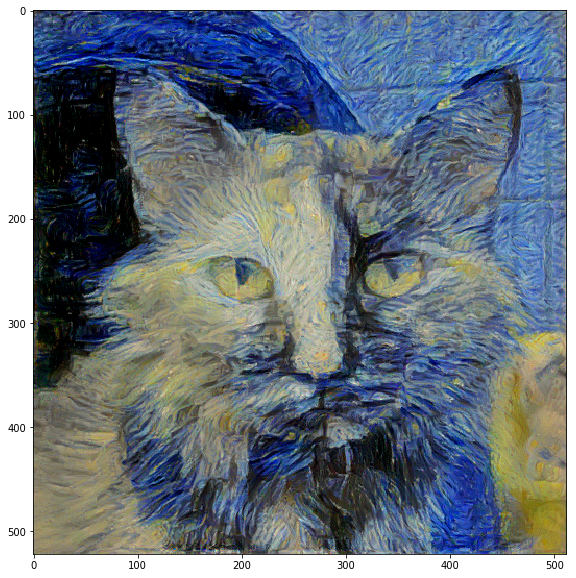

In [111]:
out_img_hr = postp(opt_img.data[0].cpu().squeeze())

imshow(out_img_hr)
gcf().set_size_inches(10,10)